In [1]:

import os, shutil
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
import cv2
import shutil

from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

In [2]:
#get working directory
os.getcwd()

'C:\\Users\\Mojtaba Jafari Tadi\\Projects_AMK\\Radiology Project\\fatpad'

In [3]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5',
 'CNN_automated_medical_diagnostics_five_layers_chopped_two_classes_trained_on_twenty_epochs_Adam_0.0001.ipynb',
 'CNN_FATPAD_MultiHeadAttention.ipynb',
 'CNN_FATPAD_ResidualAttention.ipynb',
 'CNN_FATPAD_SimplePlainNN.ipynb',
 'CNN_FATPAD_TransferLearning-DenseNet.ipynb',
 'CNN_FATPAD_TransferLearning-EfficientNet.ipynb',
 'CNN_FATPAD_TransferLearning-Inception.ipynb',
 'CNN_FATPAD_TransferLearning-NASNet.ipynb',
 'CNN_FATPAD_TransferLearning-ResNet.ipynb',
 'CNN_FATPAD_TransferLearning-Xception.ipynb',
 'CNN_FATPAD_TransferLearning.ipynb',
 'Labels_FatPadDetection.xlsx',
 'Prepare_Xray_Data.ipynb',
 'README.md',
 'ResidualAttentionNetwork.py',
 '__pycache__']

In [4]:
#change working directory to where the datasets are
root_directory=os.chdir('C:/Users/Mojtaba Jafari Tadi/Projects_AMK/Radiology Project')

In [5]:
#Provide train, validation, and test to tensorflow-keras ImageDataGenerator
base_dir_train = 'C:/Users/Mojtaba Jafari Tadi/Projects_AMK/Radiology Project/Binary_Classification_Split/train'
base_dir_validate = 'C:/Users/Mojtaba Jafari Tadi/Projects_AMK/Radiology Project/Binary_Classification_Split/validation'
base_dir_test = 'C:/Users/Mojtaba Jafari Tadi/Projects_AMK/Radiology Project/Binary_Classification_Split/test'

print(base_dir_train)

C:/Users/Mojtaba Jafari Tadi/Projects_AMK/Radiology Project/Binary_Classification_Split/train


In [45]:
#run tensorflow-keras ImageDataGenerator on the directory which contains train, validate and test

# The validation data should not be augmented (just rescaled)
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
IMAGE_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
batch_size=32
epochs = 500
num_classes = 2
train_datagen = ImageDataGenerator( rotation_range=25,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.35,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=.33)


#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        base_dir_train,
       shuffle=True,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
        base_dir_validate, 
       target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    subset='validation')

Found 2359 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


In [46]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    

In [47]:
train_generator.image_shape
##batch = train_generator.next()
#image = batch[0].astype('float32')
#image.shape
#pyplot.imshow(image[8].reshape(180,180), cmap=pyplot.get_cmap('gray'))

(128, 128, 3)

In [48]:
from matplotlib import pyplot
gr=0
if gr: 
    fig, axs = plt.subplots(3,3, figsize=(15, 15), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(9):
        # define subplot
        # generate batch of images
        batch = train_generator.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        # plot raw pixel data
        axs[i].imshow(image[i].reshape(180,180), cmap=pyplot.get_cmap('gray'))# show the figure


In [49]:
#load the root model and load trained weights into it
print(train_generator.n)
steps_per_epoch = int(train_generator.n/32)
print(steps_per_epoch)
validation_steps=int(validation_generator.n/32)
print(validation_steps)

2359
73
10


In [50]:
# should add smoothing to these plots
def plot_history(h):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [132]:
input_shape = IMAGE_SHAPE
learning_rate = 0.01
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = IMAGE_HEIGHT# We'll resize input images to this size
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [1024, 512, 256, 128, 64]  # Size of the dense layers of the final classifier

In [133]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 32 X 32
Patches per image: 16
Elements per patch: 3072


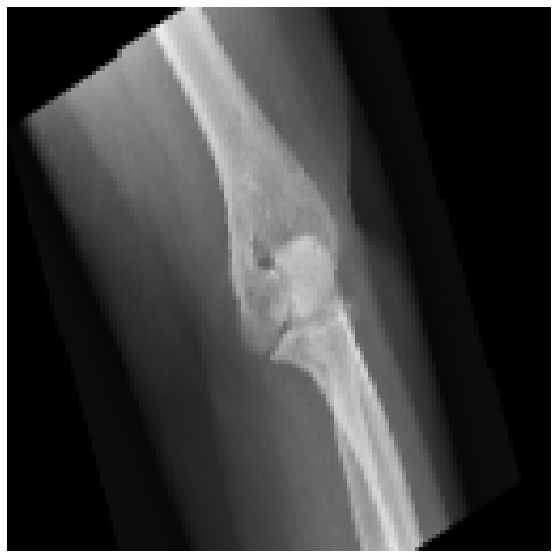

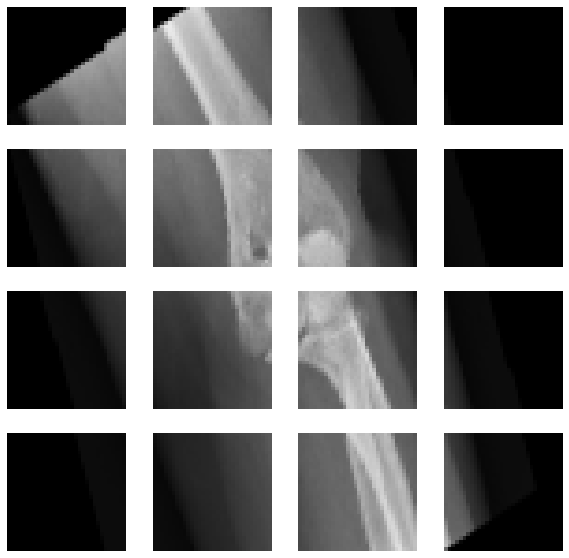

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
batch = train_generator.next()
        # convert to unsigned integers for viewing
image = batch[0]
image = image[0]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [135]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [136]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


def conv_block(filters, inputs):
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [137]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [138]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    # Create patches.
    patches = Patches(patch_size)(x)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    print(encoded_patches.shape)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2,activation="softmax")(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model

In [139]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [140]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    #optimizer=
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    checkpoint_filepath = "./checkpoints"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_generator,
      epochs=num_epochs,
    steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
      verbose=1, callbacks=[checkpoint_callback])

   # model.load_weights(checkpoint_filepath)
   # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
   #print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()


(None, 16, 32)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 128, 128, 16) 448         input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_140[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_70 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_141[0][0]                 
____________________________________________________________________________

In [141]:
history = run_experiment(vit_classifier)

Epoch 1/100
73/73 [==============================] - 42s 534ms/step - loss: 2.5404 - accuracy: 0.4910 - val_loss: 0.6925 - val_accuracy: 0.5156
Epoch 2/100
73/73 [==============================] - 38s 525ms/step - loss: 0.7353 - accuracy: 0.4950 - val_loss: 0.6937 - val_accuracy: 0.5031
Epoch 3/100
73/73 [==============================] - 38s 525ms/step - loss: 0.7032 - accuracy: 0.5222 - val_loss: 0.6945 - val_accuracy: 0.5063
Epoch 4/100
73/73 [==============================] - 38s 524ms/step - loss: 0.7086 - accuracy: 0.4986 - val_loss: 0.7576 - val_accuracy: 0.4938
Epoch 5/100
73/73 [==============================] - 38s 525ms/step - loss: 0.7087 - accuracy: 0.5300 - val_loss: 0.6971 - val_accuracy: 0.5125
Epoch 6/100
73/73 [==============================] - 39s 529ms/step - loss: 0.6971 - accuracy: 0.5286 - val_loss: 0.6931 - val_accuracy: 0.5188
Epoch 7/100
73/73 [==============================] - 38s 523ms/step - loss: 0.6941 - accuracy: 0.4930 - val_loss: 0.6933 - val_accuracy:

73/73 [==============================] - 38s 523ms/step - loss: 0.6948 - accuracy: 0.4709 - val_loss: 0.6927 - val_accuracy: 0.5188
Epoch 58/100
73/73 [==============================] - 38s 524ms/step - loss: 1.1462 - accuracy: 0.5076 - val_loss: 0.6922 - val_accuracy: 0.5219
Epoch 59/100
73/73 [==============================] - 38s 525ms/step - loss: 0.7180 - accuracy: 0.5167 - val_loss: 0.6929 - val_accuracy: 0.5156
Epoch 60/100
73/73 [==============================] - 38s 526ms/step - loss: 0.6931 - accuracy: 0.5123 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 61/100
73/73 [==============================] - 38s 524ms/step - loss: 0.6934 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy: 0.5156
Epoch 62/100
73/73 [==============================] - 38s 523ms/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6926 - val_accuracy: 0.5188
Epoch 63/100
73/73 [==============================] - 38s 524ms/step - loss: 0.7054 - accuracy: 0.5265 - val_loss: 0.6931 - val_accuracy: 0.525